In [18]:
# --- Device Setup (Fixes NameError) ---
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [19]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from scipy.fft import fft
from scipy.signal import find_peaks
from scipy.spatial import Delaunay
import mediapipe as mp
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import torch.nn.functional as F
from scipy.io import wavfile
from scipy.fftpack import dct
from scipy import signal
import subprocess

In [20]:
# --- Data Augmentation for Landmarks (ENHANCED for Better Generalization) ---
def augment_landmarks(landmarks):
    """
    Enhanced augmentation with scaling, shear, and rotation for better generalization.
    Simulates diverse faces, lighting conditions, and camera angles.
    """
    if landmarks is None or len(landmarks) == 0:
        return landmarks
    lm = np.array(landmarks, dtype=np.float32)  # shape (N, 3)
    
    # Horizontal flip with 50%
    if random.random() < 0.5:
        lm[:, 0] = 1.0 - lm[:, 0]
    
    # Small rotation around image center
    if random.random() < 0.3:
        angle = random.uniform(-15, 15)
        theta = np.radians(angle)
        rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        xy = lm[:, :2] - 0.5
        xy = xy.dot(rot.T) + 0.5
        lm[:, :2] = xy
    
    # Scaling (simulate distance/zoom variations)
    if random.random() < 0.3:
        scale = random.uniform(0.9, 1.1)
        center = np.array([0.5, 0.5])
        lm[:, :2] = (lm[:, :2] - center) * scale + center
        lm[:, :2] = np.clip(lm[:, :2], 0.0, 1.0)
        # Scale z-coordinate too (depth)
        lm[:, 2:3] *= scale
    
    # Shear transformation (slight face distortion)
    if random.random() < 0.2:
        shear_x = random.uniform(-0.1, 0.1)
        shear_y = random.uniform(-0.1, 0.1)
        lm[:, 0] += shear_x * lm[:, 1]  # x shift proportional to y
        lm[:, 1] += shear_y * lm[:, 0]  # y shift proportional to x
        lm[:, :2] = np.clip(lm[:, :2], 0.0, 1.0)
    
    # Small gaussian noise
    if random.random() < 0.2:
        noise_xy = np.random.normal(0, 0.01, size=lm[:, :2].shape)
        noise_z = np.random.normal(0, 0.002, size=(lm.shape[0], 1))
        lm[:, :2] += noise_xy
        lm[:, 2:] += noise_z
    
    lm[:, :2] = np.clip(lm[:, :2], 0.0, 1.0)
    return [tuple(row) for row in lm.tolist()]

In [21]:
# Initialize MediaPipe
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.3,
    min_tracking_confidence=0.5
)
mp_drawing = mp.solutions.drawing_utils

In [22]:
# --- Landmark Indices ---
left_brow_idx = [70, 63, 105, 66, 107, 55, 65, 52, 53, 46]
right_brow_idx = [300, 293, 334, 296, 336, 285, 295, 282, 283, 276]
inner_brow_idx = [63, 293]
brow_landmarks_idx = list(set(left_brow_idx + right_brow_idx + inner_brow_idx))

left_cheek_idx = [205, 206, 216, 204, 207, 114, 115, 116, 213, 214, 215]
right_cheek_idx = [425, 426, 436, 424, 427, 343, 344, 345, 433, 434, 435]
cheek_landmarks_idx = list(set(left_cheek_idx + right_cheek_idx))

left_eye_idx = [33, 160, 158, 133, 153, 144, 145, 159]
right_eye_idx = [362, 385, 387, 263, 373, 374, 380, 386]
outer_eye_idx = [33, 133, 362, 263]
eye_landmarks_idx = list(set(left_eye_idx + right_eye_idx + outer_eye_idx))

jaw_landmarks_idx = [152, 176, 136, 172, 397, 365, 366, 379, 400, 378, 377]

lip_landmarks_idx = [13, 14, 37, 39, 40, 61, 78, 80, 81, 82, 84, 91, 95, 146, 178, 181, 185, 191, 267, 269, 270, 291, 308, 310, 311, 312, 314, 321, 324, 375, 402, 405, 409, 415]

mouth_landmarks_idx = [13, 14, 17, 37, 39, 40, 61, 78, 80, 81, 82, 84, 87, 88, 91, 95, 146, 178, 181, 185, 191, 267, 269, 270, 291, 308, 310, 311, 312, 314, 317, 318, 321, 324, 375, 402, 405, 409, 415]

# --- LEFT / RIGHT Surface Vector Splits ---
left_brow_idx_surface = [70, 63, 105, 66, 107, 55, 65, 52, 53, 46]
right_brow_idx_surface = [300, 293, 334, 296, 336, 285, 295, 282, 283, 276]

left_cheek_idx_surface = [205, 206, 216, 204, 207, 114, 115, 116]
right_cheek_idx_surface = [425, 426, 436, 424, 427, 343, 344, 345]

left_eye_idx_surface = [33, 160, 158, 133, 153, 144, 145, 159]
right_eye_idx_surface = [362, 385, 387, 263, 373, 374, 380, 386]

left_jaw_idx_surface = [152, 176, 136, 172]
right_jaw_idx_surface = [397, 365, 366, 379, 400, 378, 377]

left_lip_idx_surface = [61, 78, 80, 81, 82, 84, 91, 95]
right_lip_idx_surface = [291, 308, 310, 311, 312, 314, 321, 324]

left_mouth_idx_surface = [61, 78, 80, 81, 82, 84, 87, 88, 91, 95, 17]
right_mouth_idx_surface = [291, 308, 310, 311, 312, 314, 317, 318, 321, 324, 375]


In [23]:
# --- Buffers ---
buffer_size = 10
brow_raise_buffer = deque(maxlen=buffer_size)
brow_left_raise_buffer = deque(maxlen=buffer_size)
brow_right_raise_buffer = deque(maxlen=buffer_size)
brow_inner_raise_buffer = deque(maxlen=buffer_size)
brow_vel_buffer = deque(maxlen=buffer_size)
brow_surface_var_buffer = deque(maxlen=buffer_size)
brow_surface_dir_buffer = deque(maxlen=buffer_size)

cheek_raise_buffer = deque(maxlen=buffer_size)
cheek_vel_buffer = deque(maxlen=buffer_size)
cheek_surface_var_buffer = deque(maxlen=buffer_size)
cheek_surface_dir_buffer = deque(maxlen=buffer_size)

eye_ratio_buffer = deque(maxlen=buffer_size)
eye_vel_buffer = deque(maxlen=buffer_size)
blink_buffer = deque(maxlen=30)
eye_surface_var_buffer = deque(maxlen=buffer_size)
eye_surface_dir_buffer = deque(maxlen=buffer_size)

jaw_open_buffer = deque(maxlen=buffer_size)
jaw_vel_buffer = deque(maxlen=buffer_size)
jaw_surface_var_buffer = deque(maxlen=buffer_size)
jaw_surface_dir_buffer = deque(maxlen=buffer_size)

lips_open_buffer = deque(maxlen=buffer_size)
lips_vel_buffer = deque(maxlen=buffer_size)
lips_surface_var_buffer = deque(maxlen=buffer_size)
lips_surface_dir_buffer = deque(maxlen=buffer_size)

mouth_open_buffer = deque(maxlen=buffer_size)
mouth_vel_buffer = deque(maxlen=buffer_size)
mouth_surface_var_buffer = deque(maxlen=buffer_size)
mouth_surface_dir_buffer = deque(maxlen=buffer_size)

In [24]:
# --- Surface Vector Split Function ---
def compute_surface_vectors_split(landmarks, prev_landmarks, left_idx, right_idx):
    if prev_landmarks is None or landmarks is None:
        zero = {'vectors': np.array([]), 'positions': [], 'norms': np.array([]), 'mean_mag': 0.0, 'var': 0.0, 'angle': 0.0}
        return {'left': zero, 'right': zero}

    def process_side(idx_list):
        if not idx_list:
            return {'vectors': np.array([]), 'positions': [], 'norms': np.array([]), 'mean_mag': 0.0, 'var': 0.0, 'angle': 0.0}

        curr_pos = []
        prev_pos = []
        for idx in idx_list:
            if idx >= len(landmarks) or idx >= len(prev_landmarks):
                continue
            curr_pos.append(np.array(landmarks[idx]))
            prev_pos.append(np.array(prev_landmarks[idx]))

        if len(curr_pos) < 3:
            return {'vectors': np.array([]), 'positions': [], 'norms': np.array([]), 'mean_mag': 0.0, 'var': 0.0, 'angle': 0.0}

        points2d = np.array([p[:2] for p in curr_pos])

        try:
            tri = Delaunay(points2d)
        except:
            return {'vectors': np.array([]), 'positions': [], 'norms': np.array([]), 'mean_mag': 0.0, 'var': 0.0, 'angle': 0.0}

        triangle_norms = []
        triangle_vectors = []
        triangle_areas = []

        for simplex in tri.simplices:
            i1, i2, i3 = simplex
            v1 = curr_pos[i1] - prev_pos[i1]
            v2 = curr_pos[i2] - prev_pos[i2]
            v3 = curr_pos[i3] - prev_pos[i3]
            mean_v = (v1 + v2 + v3) / 3
            norm = np.linalg.norm(mean_v)
            triangle_norms.append(norm)
            if norm > 1e-6:
                triangle_vectors.append(mean_v / norm)
            else:
                triangle_vectors.append(mean_v)
            area = 0.5 * np.abs(np.cross(points2d[i2] - points2d[i1], points2d[i3] - points2d[i1]))
            triangle_areas.append(area)

        triangle_norms = np.array(triangle_norms)
        mean_mag = np.mean(triangle_norms) if len(triangle_norms) > 0 else 0.0
        var = np.var(triangle_norms) if len(triangle_norms) > 0 else 0.0

        angle = 0.0
        if triangle_vectors and triangle_areas:
            weighted_vectors = np.array(triangle_vectors) * np.array(triangle_areas)[:, np.newaxis]
            avg = np.sum(weighted_vectors[:, :2], axis=0) / np.sum(triangle_areas)
            n = np.linalg.norm(avg)
            if n > 1e-6:
                angle = np.arctan2(avg[1], avg[0])

        vectors = np.array(triangle_vectors) if triangle_vectors else np.array([])
        norms = triangle_norms
        positions = [np.mean([curr_pos[i] for i in s], axis=0) for s in tri.simplices]

        return {'vectors': vectors, 'positions': positions, 'norms': norms, 'mean_mag': mean_mag, 'var': var, 'angle': angle}

    return {'left': process_side(left_idx), 'right': process_side(right_idx)}


In [25]:
# --- BROW ---
def compute_brow_features(landmarks, prev_landmarks):
    if landmarks is None: return {}
    nose_tip = np.array(landmarks[1])
    norm_landmarks = [np.array(lm) - nose_tip for lm in landmarks]

    left_brow_ys = [norm_landmarks[i][1] for i in left_brow_idx]
    right_brow_ys = [norm_landmarks[i][1] for i in right_brow_idx]
    inner_brow_ys = [norm_landmarks[i][1] for i in inner_brow_idx]

    left_raise = -np.mean(left_brow_ys)
    right_raise = -np.mean(right_brow_ys)
    inner_raise = -np.mean(inner_brow_ys)
    overall_raise = (left_raise + right_raise) / 2

    brow_left_raise_buffer.append(left_raise)
    brow_right_raise_buffer.append(right_raise)
    brow_inner_raise_buffer.append(inner_raise)
    brow_raise_buffer.append(overall_raise)

    left_stats = [np.mean(brow_left_raise_buffer), np.std(brow_left_raise_buffer)] if len(brow_left_raise_buffer) > 1 else [0, 0]
    right_stats = [np.mean(brow_right_raise_buffer), np.std(brow_right_raise_buffer)] if len(brow_right_raise_buffer) > 1 else [0, 0]
    inner_stats = [np.mean(brow_inner_raise_buffer), np.std(brow_inner_raise_buffer)] if len(brow_inner_raise_buffer) > 1 else [0, 0]

    brow_vel = abs(overall_raise - brow_raise_buffer[-2]) if len(brow_raise_buffer) > 1 else 0
    brow_vel_buffer.append(brow_vel)
    vel_stats = [np.mean(brow_vel_buffer), np.std(brow_vel_buffer)] if len(brow_vel_buffer) > 1 else [0, 0]
    rapid_count = len(find_peaks(list(brow_vel_buffer), distance=2)[0]) if len(brow_vel_buffer) > 1 else 0

    micro_var = np.var(brow_raise_buffer) if len(brow_raise_buffer) > 1 else 0.0
    freq_mean = np.mean(np.abs(fft(list(brow_raise_buffer)))[:buffer_size//2]) if len(brow_raise_buffer) == buffer_size else 0.0
    peak_freq = np.max(np.abs(fft(list(brow_raise_buffer)))[:buffer_size//2]) if len(brow_raise_buffer) == buffer_size else 0.0

    brow_asym = abs(left_raise - right_raise)
    inner_asym = abs(norm_landmarks[63][1] - norm_landmarks[293][1])
    asym_diffs = np.abs(np.array(brow_left_raise_buffer) - np.array(brow_right_raise_buffer))
    temp_asym_var = np.var(asym_diffs) if len(asym_diffs) > 1 else 0.0

    surface = compute_surface_vectors_split(landmarks, prev_landmarks, left_brow_idx_surface, right_brow_idx_surface)
    left, right = surface['left'], surface['right']

    brow_surface_var_buffer.append({'left': left['var'], 'right': right['var']})
    brow_surface_dir_buffer.append({'left': left['angle'], 'right': right['angle']})

    left_vars = [x['left'] for x in list(brow_surface_var_buffer)[-10:]]
    right_vars = [x['right'] for x in list(brow_surface_var_buffer)[-10:]]
    left_angles = [x['left'] for x in list(brow_surface_dir_buffer)[-10:]]
    right_angles = [x['right'] for x in list(brow_surface_dir_buffer)[-10:]]

    var_stats_l = [np.mean(left_vars), np.std(left_vars), np.min(left_vars), np.max(left_vars)] if left_vars else [0]*4
    var_stats_r = [np.mean(right_vars), np.std(right_vars), np.min(right_vars), np.max(right_vars)] if right_vars else [0]*4
    dir_stats_l = [np.mean(left_angles), np.std(left_angles)] if len(left_angles) > 1 else [0, 0]
    dir_stats_r = [np.mean(right_angles), np.std(right_angles)] if len(right_angles) > 1 else [0, 0]

    return {
        'Brow micro-expression variance mean': micro_var,
        'Brow micro-expression rapid changes count': rapid_count,
        'Brow velocity (mean)': vel_stats[0],
        'Brow velocity (std)': vel_stats[1],
        'Right brow raise (mean)': right_stats[0],
        'Right brow raise (std)': right_stats[1],
        'Left brow raise (mean)': left_stats[0],
        'Left brow raise (std)': left_stats[1],
        'Inner brow raise (mean)': inner_stats[0],
        'Inner brow raise (std)': inner_stats[1],
        'Brow asymmetry (mean)': brow_asym,
        'Temporal brow asymmetry variance': temp_asym_var,
        'Brow frequency mean': freq_mean,
        'Brow peak frequency': peak_freq,

        'Left surface vector magnitude mean': left['mean_mag'],
        'Left surface variance (current)': left['var'],
        'Left surface variance mean': var_stats_l[0],
        'Left surface variance std': var_stats_l[1],
        'Left surface variance min': var_stats_l[2],
        'Left surface variance max': var_stats_l[3],
        'Left surface dominant angle mean': dir_stats_l[0],
        'Left surface dominant angle std': dir_stats_l[1],

        'Right surface vector magnitude mean': right['mean_mag'],
        'Right surface variance (current)': right['var'],
        'Right surface variance mean': var_stats_r[0],
        'Right surface variance std': var_stats_r[1],
        'Right surface variance min': var_stats_r[2],
        'Right surface variance max': var_stats_r[3],
        'Right surface dominant angle mean': dir_stats_r[0],
        'Right surface dominant angle std': dir_stats_r[1],
    }


# --- CHEEK ---
def compute_cheek_features(landmarks, prev_landmarks):
    if landmarks is None: return {}
    nose_tip = np.array(landmarks[1])
    norm_landmarks = [np.array(lm) - nose_tip for lm in landmarks]

    left_ys = [norm_landmarks[i][1] for i in left_cheek_idx if i < len(norm_landmarks)]
    left_xs = [norm_landmarks[i][0] for i in left_cheek_idx if i < len(norm_landmarks)]
    right_ys = [norm_landmarks[i][1] for i in right_cheek_idx if i < len(norm_landmarks)]
    right_xs = [norm_landmarks[i][0] for i in right_cheek_idx if i < len(norm_landmarks)]

    left_raise = -np.mean(left_ys) + np.mean(left_xs) if left_ys else 0
    right_raise = -np.mean(right_ys) + np.mean(right_xs) if right_ys else 0
    overall = (left_raise + right_raise) / 2

    cheek_raise_buffer.append(overall)
    stats = [np.mean(cheek_raise_buffer), np.std(cheek_raise_buffer)] if len(cheek_raise_buffer) > 1 else [0, 0]
    vel = abs(overall - cheek_raise_buffer[-2]) if len(cheek_raise_buffer) > 1 else 0
    cheek_vel_buffer.append(vel)
    vel_stats = [np.mean(cheek_vel_buffer), np.std(cheek_vel_buffer)] if len(cheek_vel_buffer) > 1 else [0, 0]
    rapid = len(find_peaks(list(cheek_vel_buffer), distance=2)[0]) if len(cheek_vel_buffer) > 1 else 0
    var = np.var(cheek_raise_buffer) if len(cheek_raise_buffer) > 1 else 0
    freq = np.mean(np.abs(fft(list(cheek_raise_buffer)))[:buffer_size//2]) if len(cheek_raise_buffer) == buffer_size else 0

    asym = abs(left_raise - right_raise)
    surface = compute_surface_vectors_split(landmarks, prev_landmarks, left_cheek_idx_surface, right_cheek_idx_surface)
    l, r = surface['left'], surface['right']
    cheek_surface_var_buffer.append({'left': l['var'], 'right': r['var']})
    cheek_surface_dir_buffer.append({'left': l['angle'], 'right': r['angle']})

    lv = [x['left'] for x in list(cheek_surface_var_buffer)[-10:]]
    rv = [x['right'] for x in list(cheek_surface_var_buffer)[-10:]]
    la = [x['left'] for x in list(cheek_surface_dir_buffer)[-10:]]
    ra = [x['right'] for x in list(cheek_surface_dir_buffer)[-10:]]

    vl = [np.mean(lv), np.std(lv), np.min(lv), np.max(lv)] if lv else [0]*4
    vr = [np.mean(rv), np.std(rv), np.min(rv), np.max(rv)] if rv else [0]*4
    dl = [np.mean(la), np.std(la)] if len(la) > 1 else [0, 0]
    dr = [np.mean(ra), np.std(ra)] if len(ra) > 1 else [0, 0]

    return {
        'Cheek puff micro-expression variance mean': var,
        'Cheek puff rapid changes count': rapid,
        'Cheek raise (mean)': stats[0],
        'Cheek raise (std)': stats[1],
        'Cheek velocity (mean)': vel_stats[0],
        'Cheek velocity (std)': vel_stats[1],
        'Cheek frequency mean': freq,
        'Cheek asymmetry (mean)': asym,

        'Left surface vector magnitude mean': l['mean_mag'],
        'Left surface variance (current)': l['var'],
        'Left surface variance mean': vl[0],
        'Left surface variance std': vl[1],
        'Left surface variance min': vl[2],
        'Left surface variance max': vl[3],
        'Left surface dominant angle mean': dl[0],
        'Left surface dominant angle std': dl[1],

        'Right surface vector magnitude mean': r['mean_mag'],
        'Right surface variance (current)': r['var'],
        'Right surface variance mean': vr[0],
        'Right surface variance std': vr[1],
        'Right surface variance min': vr[2],
        'Right surface variance max': vr[3],
        'Right surface dominant angle mean': dr[0],
        'Right surface dominant angle std': dr[1],
    }

# --- EYE ---
def compute_eye_features(landmarks, prev_landmarks):
    if landmarks is None: return {}
    nose_tip = np.array(landmarks[1])
    norm_landmarks = [np.array(lm) - nose_tip for lm in landmarks]

    lu = (norm_landmarks[159][1] + norm_landmarks[158][1] + norm_landmarks[160][1]) / 3
    ll = (norm_landmarks[145][1] + norm_landmarks[144][1] + norm_landmarks[153][1]) / 3
    lw = abs(norm_landmarks[33][0] - norm_landmarks[133][0])
    left_ratio = abs(lu - ll) / lw if lw > 0 else 0

    ru = (norm_landmarks[386][1] + norm_landmarks[387][1] + norm_landmarks[385][1]) / 3
    rl = (norm_landmarks[374][1] + norm_landmarks[373][1] + norm_landmarks[380][1]) / 3
    rw = abs(norm_landmarks[362][0] - norm_landmarks[263][0])
    right_ratio = abs(ru - rl) / rw if rw > 0 else 0

    ratio = (left_ratio + right_ratio) / 2
    eye_ratio_buffer.append(ratio)
    stats = [np.mean(eye_ratio_buffer), np.std(eye_ratio_buffer)] if len(eye_ratio_buffer) > 1 else [0, 0]
    vel = abs(ratio - eye_ratio_buffer[-2]) if len(eye_ratio_buffer) > 1 else 0
    eye_vel_buffer.append(vel)
    vel_stats = [np.mean(eye_vel_buffer), np.std(eye_vel_buffer)] if len(eye_vel_buffer) > 1 else [0, 0]
    rapid = len(find_peaks(list(eye_vel_buffer), distance=2)[0]) if len(eye_vel_buffer) > 1 else 0
    var = np.var(eye_ratio_buffer) if len(eye_ratio_buffer) > 1 else 0
    blink = 1 if ratio < 0.1 else 0
    blink_buffer.append(blink)
    blink_rate = sum(blink_buffer) / len(blink_buffer) if blink_buffer else 0

    surface = compute_surface_vectors_split(landmarks, prev_landmarks, left_eye_idx_surface, right_eye_idx_surface)
    l, r = surface['left'], surface['right']
    eye_surface_var_buffer.append({'left': l['var'], 'right': r['var']})
    eye_surface_dir_buffer.append({'left': l['angle'], 'right': r['angle']})

    lv = [x['left'] for x in list(eye_surface_var_buffer)[-10:]]
    rv = [x['right'] for x in list(eye_surface_var_buffer)[-10:]]
    la = [x['left'] for x in list(eye_surface_dir_buffer)[-10:]]
    ra = [x['right'] for x in list(eye_surface_dir_buffer)[-10:]]

    vl = [np.mean(lv), np.std(lv), np.min(lv), np.max(lv)] if lv else [0]*4
    vr = [np.mean(rv), np.std(rv), np.min(rv), np.max(rv)] if rv else [0]*4
    dl = [np.mean(la), np.std(la)] if len(la) > 1 else [0, 0]
    dr = [np.mean(ra), np.std(ra)] if len(ra) > 1 else [0, 0]

    return {
        'Eye widening micro-expression variance mean': var,
        'Eye widening rapid changes count': rapid,
        'Eye ratio (mean)': stats[0],
        'Eye ratio (std)': stats[1],
        'Blink rate': blink_rate,
        'Eye squint velocity (mean)': vel_stats[0],
        'Eye squint velocity (std)': vel_stats[1],

        'Left surface vector magnitude mean': l['mean_mag'],
        'Left surface variance (current)': l['var'],
        'Left surface variance mean': vl[0],
        'Left surface variance std': vl[1],
        'Left surface variance min': vl[2],
        'Left surface variance max': vl[3],
        'Left surface dominant angle mean': dl[0],
        'Left surface dominant angle std': dl[1],

        'Right surface vector magnitude mean': r['mean_mag'],
        'Right surface variance (current)': r['var'],
        'Right surface variance mean': vr[0],
        'Right surface variance std': vr[1],
        'Right surface variance min': vr[2],
        'Right surface variance max': vr[3],
        'Right surface dominant angle mean': dr[0],
        'Right surface dominant angle std': dr[1],
    }

# --- JAW ---
def compute_jaw_features(landmarks, prev_landmarks):
    if landmarks is None: return {}
    nose_tip = np.array(landmarks[1])
    norm_landmarks = [np.array(lm) - nose_tip for lm in landmarks]

    chin = norm_landmarks[152]
    upper_jaw_ref = norm_landmarks[13]
    jaw_open = np.linalg.norm(chin - upper_jaw_ref)
    jaw_open_buffer.append(jaw_open)
    jaw_open_stats = [np.mean(jaw_open_buffer), np.std(jaw_open_buffer), np.min(jaw_open_buffer), np.max(jaw_open_buffer)] if len(jaw_open_buffer) > 1 else [0.0, 0.0, 0.0, 0.0]

    jaw_vel = abs(jaw_open - jaw_open_buffer[-2]) if len(jaw_open_buffer) > 1 else 0
    jaw_vel_buffer.append(jaw_vel)
    jaw_vel_stats = [np.mean(jaw_vel_buffer), np.std(jaw_vel_buffer)] if len(jaw_vel_buffer) > 1 else [0.0, 0.0]

    left_jaw = norm_landmarks[136]
    right_jaw = norm_landmarks[400]
    jaw_asym = np.abs(left_jaw[0] - right_jaw[0])
    jaw_asym_stats = [np.mean([jaw_asym]), np.std([jaw_asym]), np.max([jaw_asym])] if len(jaw_open_buffer) > 1 else [0.0, 0.0, 0.0]

    rapid_count = len(find_peaks(list(jaw_vel_buffer), distance=2)[0]) if len(jaw_vel_buffer) > 1 else 0
    sig_mov_count = sum(1 for v in jaw_vel_buffer if v > 0.001)

    freq_mean = np.mean(np.abs(fft(list(jaw_open_buffer)))[:buffer_size//2]) if len(jaw_open_buffer) == buffer_size else 0.0
    peak_freq = np.max(np.abs(fft(list(jaw_open_buffer)))[:buffer_size//2]) if len(jaw_open_buffer) == buffer_size else 0.0

    surface = compute_surface_vectors_split(landmarks, prev_landmarks, left_jaw_idx_surface, right_jaw_idx_surface)
    l, r = surface['left'], surface['right']
    jaw_surface_var_buffer.append({'left': l['var'], 'right': r['var']})
    jaw_surface_dir_buffer.append({'left': l['angle'], 'right': r['angle']})

    lv = [x['left'] for x in list(jaw_surface_var_buffer)[-10:]]
    rv = [x['right'] for x in list(jaw_surface_var_buffer)[-10:]]
    la = [x['left'] for x in list(jaw_surface_dir_buffer)[-10:]]
    ra = [x['right'] for x in list(jaw_surface_dir_buffer)[-10:]]

    vl = [np.mean(lv), np.std(lv), np.min(lv), np.max(lv)] if lv else [0]*4
    vr = [np.mean(rv), np.std(rv), np.min(rv), np.max(rv)] if rv else [0]*4
    dl = [np.mean(la), np.std(la)] if len(la) > 1 else [0, 0]
    dr = [np.mean(ra), np.std(ra)] if len(ra) > 1 else [0, 0]

    return {
        'Jaw opening (mean)': jaw_open_stats[0],
        'Jaw opening (std)': jaw_open_stats[1],
        'Jaw opening (min)': jaw_open_stats[2],
        'Jaw opening (max)': jaw_open_stats[3],
        'Jaw velocity (mean)': jaw_vel_stats[0],
        'Jaw velocity (std)': jaw_vel_stats[1],
        'Jaw asymmetry (mean)': jaw_asym_stats[0],
        'Jaw asymmetry (std)': jaw_asym_stats[1],
        'Jaw asymmetry (max)': jaw_asym_stats[2],
        'Jaw rapid changes count': rapid_count,
        'Jaw significant movements count': sig_mov_count,
        'Jaw frequency mean': freq_mean,
        'Jaw peak frequency': peak_freq,

        'Left surface vector magnitude mean': l['mean_mag'],
        'Left surface variance (current)': l['var'],
        'Left surface variance mean': vl[0],
        'Left surface variance std': vl[1],
        'Left surface variance min': vl[2],
        'Left surface variance max': vl[3],
        'Left surface dominant angle mean': dl[0],
        'Left surface dominant angle std': dl[1],

        'Right surface vector magnitude mean': r['mean_mag'],
        'Right surface variance (current)': r['var'],
        'Right surface variance mean': vr[0],
        'Right surface variance std': vr[1],
        'Right surface variance min': vr[2],
        'Right surface variance max': vr[3],
        'Right surface dominant angle mean': dr[0],
        'Right surface dominant angle std': dr[1],
    }

# --- LIPS ---
def compute_lips_features(landmarks, prev_landmarks):
    if landmarks is None: return {}
    nose_tip = np.array(landmarks[1])
    norm_landmarks = [np.array(lm) - nose_tip for lm in landmarks]

    upper_lip = norm_landmarks[13]
    lower_lip = norm_landmarks[14]
    lip_open = np.linalg.norm(upper_lip - lower_lip)
    lips_open_buffer.append(lip_open)
    lip_open_stats = [np.mean(lips_open_buffer), np.std(lips_open_buffer), np.min(lips_open_buffer), np.max(lips_open_buffer)] if len(lips_open_buffer) > 1 else [0.0, 0.0, 0.0, 0.0]

    lip_vel = abs(lip_open - lips_open_buffer[-2]) if len(lips_open_buffer) > 1 else 0
    lips_vel_buffer.append(lip_vel)
    lip_vel_stats = [np.mean(lips_vel_buffer), np.std(lips_vel_buffer)] if len(lips_vel_buffer) > 1 else [0.0, 0.0]

    micro_var = np.var(lips_open_buffer) if len(lips_open_buffer) > 1 else 0.0
    rapid_count = len(find_peaks(list(lips_vel_buffer), distance=2)[0]) if len(lips_vel_buffer) > 1 else 0
    sig_mov_count = sum(1 for v in lips_vel_buffer if v > 0.001)

    freq_mean = np.mean(np.abs(fft(list(lips_open_buffer)))[:buffer_size//2]) if len(lips_open_buffer) == buffer_size else 0.0
    peak_freq = np.max(np.abs(fft(list(lips_open_buffer)))[:buffer_size//2]) if len(lips_open_buffer) == buffer_size else 0.0

    left_corner_y = norm_landmarks[61][1] - norm_landmarks[17][1]
    right_corner_y = norm_landmarks[291][1] - norm_landmarks[17][1]
    corner_asym = np.abs(left_corner_y - right_corner_y)
    corner_asym_stats = [np.mean([corner_asym]), np.std([corner_asym]), np.max([corner_asym])] if len(lips_open_buffer) > 1 else [0.0, 0.0, 0.0]

    surface = compute_surface_vectors_split(landmarks, prev_landmarks, left_lip_idx_surface, right_lip_idx_surface)
    l, r = surface['left'], surface['right']
    lips_surface_var_buffer.append({'left': l['var'], 'right': r['var']})
    lips_surface_dir_buffer.append({'left': l['angle'], 'right': r['angle']})

    lv = [x['left'] for x in list(lips_surface_var_buffer)[-10:]]
    rv = [x['right'] for x in list(lips_surface_var_buffer)[-10:]]
    la = [x['left'] for x in list(lips_surface_dir_buffer)[-10:]]
    ra = [x['right'] for x in list(lips_surface_dir_buffer)[-10:]]

    vl = [np.mean(lv), np.std(lv), np.min(lv), np.max(lv)] if lv else [0]*4
    vr = [np.mean(rv), np.std(rv), np.min(rv), np.max(rv)] if rv else [0]*4
    dl = [np.mean(la), np.std(la)] if len(la) > 1 else [0, 0]
    dr = [np.mean(ra), np.std(ra)] if len(ra) > 1 else [0, 0]

    return {
        'Lip micro-expression variance mean': micro_var,
        'Lip micro-expression rapid changes count': rapid_count,
        'Lip opening (mean)': lip_open_stats[0],
        'Lip opening (std)': lip_open_stats[1],
        'Lip opening (min)': lip_open_stats[2],
        'Lip opening (max)': lip_open_stats[3],
        'Lip velocity (mean)': lip_vel_stats[0],
        'Lip velocity (std)': lip_vel_stats[1],
        'Lip significant movements count': sig_mov_count,
        'Lip frequency mean': freq_mean,
        'Lip peak frequency': peak_freq,
        'Lip corner asymmetry (mean)': corner_asym_stats[0],
        'Lip corner asymmetry (std)': corner_asym_stats[1],
        'Lip corner asymmetry (max)': corner_asym_stats[2],

        'Left surface vector magnitude mean': l['mean_mag'],
        'Left surface variance (current)': l['var'],
        'Left surface variance mean': vl[0],
        'Left surface variance std': vl[1],
        'Left surface variance min': vl[2],
        'Left surface variance max': vl[3],
        'Left surface dominant angle mean': dl[0],
        'Left surface dominant angle std': dl[1],

        'Right surface vector magnitude mean': r['mean_mag'],
        'Right surface variance (current)': r['var'],
        'Right surface variance mean': vr[0],
        'Right surface variance std': vr[1],
        'Right surface variance min': vr[2],
        'Right surface variance max': vr[3],
        'Right surface dominant angle mean': dr[0],
        'Right surface dominant angle std': dr[1],
    }

# --- MOUTH ---
def compute_mouth_features(landmarks, prev_landmarks):
    if landmarks is None: return {}
    nose_tip = np.array(landmarks[1])
    norm_landmarks = [np.array(lm) - nose_tip for lm in landmarks]

    upper_lip = norm_landmarks[13]
    lower_lip = norm_landmarks[14]
    mouth_open = np.linalg.norm(upper_lip - lower_lip)
    mouth_open_buffer.append(mouth_open)
    mouth_open_stats = [np.mean(mouth_open_buffer), np.std(mouth_open_buffer), np.min(mouth_open_buffer), np.max(mouth_open_buffer)] if len(mouth_open_buffer) > 1 else [0.0, 0.0, 0.0, 0.0]

    mouth_vel = abs(mouth_open - mouth_open_buffer[-2]) if len(mouth_open_buffer) > 1 else 0
    mouth_vel_buffer.append(mouth_vel)
    mouth_vel_stats = [np.mean(mouth_vel_buffer), np.std(mouth_vel_buffer)] if len(mouth_vel_buffer) > 1 else [0.0, 0.0]

    micro_var = np.var(mouth_open_buffer) if len(mouth_open_buffer) > 1 else 0.0
    rapid_count = len(find_peaks(list(mouth_vel_buffer), distance=2)[0]) if len(mouth_vel_buffer) > 1 else 0
    sig_mov_count = sum(1 for v in mouth_vel_buffer if v > 0.001)

    freq_mean = np.mean(np.abs(fft(list(mouth_open_buffer)))[:buffer_size//2]) if len(mouth_open_buffer) == buffer_size else 0.0
    peak_freq = np.max(np.abs(fft(list(mouth_open_buffer)))[:buffer_size//2]) if len(mouth_open_buffer) == buffer_size else 0.0

    left_corner_y = norm_landmarks[61][1] - norm_landmarks[17][1]
    right_corner_y = norm_landmarks[291][1] - norm_landmarks[17][1]
    corner_asym = np.abs(left_corner_y - right_corner_y)
    corner_asym_stats = [np.mean([corner_asym]), np.std([corner_asym]), np.max([corner_asym])] if len(mouth_open_buffer) > 1 else [0.0, 0.0, 0.0]

    surface = compute_surface_vectors_split(landmarks, prev_landmarks, left_mouth_idx_surface, right_mouth_idx_surface)
    l, r = surface['left'], surface['right']
    mouth_surface_var_buffer.append({'left': l['var'], 'right': r['var']})
    mouth_surface_dir_buffer.append({'left': l['angle'], 'right': r['angle']})

    lv = [x['left'] for x in list(mouth_surface_var_buffer)[-10:]]
    rv = [x['right'] for x in list(mouth_surface_var_buffer)[-10:]]
    la = [x['left'] for x in list(mouth_surface_dir_buffer)[-10:]]
    ra = [x['right'] for x in list(mouth_surface_dir_buffer)[-10:]]

    vl = [np.mean(lv), np.std(lv), np.min(lv), np.max(lv)] if lv else [0]*4
    vr = [np.mean(rv), np.std(rv), np.min(rv), np.max(rv)] if rv else [0]*4
    dl = [np.mean(la), np.std(la)] if len(la) > 1 else [0, 0]
    dr = [np.mean(ra), np.std(ra)] if len(ra) > 1 else [0, 0]

    return {
        'Mouth micro-expression variance mean': micro_var,
        'Mouth micro-expression rapid changes count': rapid_count,
        'Mouth opening (mean)': mouth_open_stats[0],
        'Mouth opening (std)': mouth_open_stats[1],
        'Mouth opening (min)': mouth_open_stats[2],
        'Mouth opening (max)': mouth_open_stats[3],
        'Mouth velocity (mean)': mouth_vel_stats[0],
        'Mouth velocity (std)': mouth_vel_stats[1],
        'Mouth significant movements count': sig_mov_count,
        'Mouth frequency mean': freq_mean,
        'Mouth peak frequency': peak_freq,
        'Mouth corner asymmetry (mean)': corner_asym_stats[0],
        'Mouth corner asymmetry (std)': corner_asym_stats[1],
        'Mouth corner asymmetry (max)': corner_asym_stats[2],

        'Left surface vector magnitude mean': l['mean_mag'],
        'Left surface variance (current)': l['var'],
        'Left surface variance mean': vl[0],
        'Left surface variance std': vl[1],
        'Left surface variance min': vl[2],
        'Left surface variance max': vl[3],
        'Left surface dominant angle mean': dl[0],
        'Left surface dominant angle std': dl[1],

        'Right surface vector magnitude mean': r['mean_mag'],
        'Right surface variance (current)': r['var'],
        'Right surface variance mean': vr[0],
        'Right surface variance std': vr[1],
        'Right surface variance min': vr[2],
        'Right surface variance max': vr[3],
        'Right surface dominant angle mean': dr[0],
        'Right surface dominant angle std': dr[1],
    }

In [26]:
# === FINAL UNIFIED & ENHANCED FACS ACTION UNITS DETECTION ===
def compute_action_units(landmarks, prev_landmarks, region_features):
    """
    Computes FACS Action Units (AU1 to AU66) with intensity and binary presence.
    Requires MediaPipe FaceMesh with refine_landmarks=True for iris landmarks (468-477).
    Uses normalized landmarks (relative to nose tip) and region_features from vTwo.py.
    """
    if landmarks is None or len(landmarks) < 478:  # 478+ landmarks needed for iris
        return {}

    au = {}

    # Normalize all landmarks relative to nose tip (landmark index 1)
    nose_tip = np.array(landmarks[1])
    norm_landmarks = [np.array(lm) - nose_tip for lm in landmarks]

    # ====================== FACIAL ACTION UNITS (AU1 - AU46) ======================

    # AU1: Inner Brow Raiser
    inner_brow_ys = [norm_landmarks[i][1] for i in inner_brow_idx]
    au['AU1_intensity'] = -np.mean(inner_brow_ys)
    au['AU1_presence'] = 1 if au['AU1_intensity'] > 0.02 else 0

    # AU2: Outer Brow Raiser
    left_outer_y = np.mean([norm_landmarks[i][1] for i in left_brow_idx[-3:]])
    right_outer_y = np.mean([norm_landmarks[i][1] for i in right_brow_idx[-3:]])
    au['AU2_intensity'] = -(left_outer_y + right_outer_y) / 2
    au['AU2_presence'] = 1 if au['AU2_intensity'] > 0.02 else 0

    # AU4: Brow Lowerer
    au['AU4_intensity'] = region_features['Brow'].get('Brow velocity (mean)', 0) if au['AU1_intensity'] < -0.01 else 0
    au['AU4_presence'] = 1 if au['AU4_intensity'] > 0.01 else 0

    # AU5: Upper Lid Raiser
    au['AU5_intensity'] = region_features['Eye'].get('Eye ratio (mean)', 0)
    au['AU5_presence'] = 1 if au['AU5_intensity'] > 0.15 else 0

    # AU6: Cheek Raiser
    au['AU6_intensity'] = region_features['Cheek'].get('Cheek raise (mean)', 0)
    au['AU6_presence'] = 1 if au['AU6_intensity'] > 0.03 else 0

    # AU7: Lid Tightener (squint)
    au['AU7_intensity'] = region_features['Eye'].get('Eye squint velocity (mean)', 0)
    au['AU7_presence'] = 1 if au['AU7_intensity'] > 0.01 else 0

    # AU8: Lips Toward Each Other
    lip_open = np.linalg.norm(norm_landmarks[13] - norm_landmarks[14])
    au['AU8_intensity'] = max(0.05 - lip_open, 0)
    au['AU8_presence'] = 1 if au['AU8_intensity'] > 0.02 else 0

    # AU9: Nose Wrinkler
    upper_lip_y = norm_landmarks[13][1]
    au['AU9_intensity'] = -upper_lip_y
    au['AU9_presence'] = 1 if au['AU9_intensity'] > 0.03 else 0

    # AU10: Upper Lip Raiser
    au['AU10_intensity'] = region_features['Lips'].get('Lip velocity (mean)', 0) if upper_lip_y < 0 else 0
    au['AU10_presence'] = 1 if au['AU10_intensity'] > 0.01 else 0

    # AU11: Nasolabial Deepener
    au['AU11_intensity'] = (
        region_features['Cheek'].get('Left surface variance mean', 0) +
        region_features['Cheek'].get('Right surface variance mean', 0)
    )
    au['AU11_presence'] = 1 if au['AU11_intensity'] > 0.02 else 0

    # AU12: Lip Corner Puller (smile)
    left_corner = norm_landmarks[61][1] - norm_landmarks[17][1]
    right_corner = norm_landmarks[291][1] - norm_landmarks[17][1]
    au['AU12_intensity'] = (left_corner + right_corner) / 2 if left_corner > 0 and right_corner > 0 else 0
    au['AU12_presence'] = 1 if au['AU12_intensity'] > 0.02 else 0

    # AU13: Cheek Puffer
    au['AU13_intensity'] = region_features['Cheek'].get('Cheek puff micro-expression variance mean', 0)
    au['AU13_presence'] = 1 if au['AU13_intensity'] > 0.02 else 0

    # AU14: Dimpler
    au['AU14_intensity'] = region_features['Cheek'].get('Cheek surface variance (current)', 0)
    au['AU14_presence'] = 1 if au['AU14_intensity'] > 0.015 else 0

    # AU15: Lip Corner Depressor (frown)
    au['AU15_intensity'] = -(left_corner + right_corner) / 2 if left_corner < 0 and right_corner < 0 else 0
    au['AU15_presence'] = 1 if au['AU15_intensity'] > 0.02 else 0

    # AU16: Lower Lip Depressor
    lower_lip_y = norm_landmarks[14][1]
    au['AU16_intensity'] = lower_lip_y
    au['AU16_presence'] = 1 if au['AU16_intensity'] > 0.03 else 0

    # AU17: Chin Raiser
    chin_y = norm_landmarks[152][1]
    au['AU17_intensity'] = -chin_y
    au['AU17_presence'] = 1 if au['AU17_intensity'] > 0.02 else 0

    # AU18: Lip Pucker
    lip_width = np.linalg.norm(norm_landmarks[61] - norm_landmarks[291])
    au['AU18_intensity'] = max(0.1 - lip_width, 0)
    au['AU18_presence'] = 1 if au['AU18_intensity'] > 0.02 else 0

    # AU20: Lip Stretcher
    au['AU20_intensity'] = lip_width
    au['AU20_presence'] = 1 if au['AU20_intensity'] > 0.15 else 0

    # AU22: Lip Funneler
    au['AU22_intensity'] = abs(region_features['Mouth'].get('Left surface dominant angle mean', 0)) + \
                            abs(region_features['Mouth'].get('Right surface dominant angle mean', 0))
    au['AU22_presence'] = 1 if au['AU22_intensity'] > 0.5 else 0

    # AU23: Lip Tightener
    au['AU23_intensity'] = region_features['Lips'].get('Lip micro-expression variance mean', 0)
    au['AU23_presence'] = 1 if au['AU23_intensity'] < 0.01 else 0

    # AU24: Lip Pressor
    au['AU24_intensity'] = region_features['Lips'].get('Lip velocity (mean)', 0) if lip_open < 0.02 else 0
    au['AU24_presence'] = 1 if au['AU24_intensity'] > 0.01 else 0

    # AU25: Lips Part
    au['AU25_intensity'] = region_features['Lips'].get('Lip opening (mean)', 0)
    au['AU25_presence'] = 1 if au['AU25_intensity'] > 0.05 else 0

    # AU26: Jaw Drop
    au['AU26_intensity'] = region_features['Jaw'].get('Jaw opening (mean)', 0)
    au['AU26_presence'] = 1 if au['AU26_intensity'] > 0.1 else 0

    # AU27: Mouth Stretch
    mouth_width = np.linalg.norm(norm_landmarks[61] - norm_landmarks[291])
    au['AU27_intensity'] = au['AU26_intensity'] * mouth_width
    au['AU27_presence'] = 1 if au['AU27_intensity'] > 0.1 else 0

    # AU28: Lip Suck
    au['AU28_intensity'] = region_features['Lips'].get('Left surface variance mean', 0) + \
                           region_features['Lips'].get('Right surface variance mean', 0)
    au['AU28_presence'] = 1 if au['AU28_intensity'] < 0.01 else 0

    # AU38: Nostril Dilator
    nostril_left = norm_landmarks[98]
    nostril_right = norm_landmarks[327]
    nostril_width = np.linalg.norm(nostril_left - nostril_right)
    au['AU38_intensity'] = nostril_width
    au['AU38_presence'] = 1 if au['AU38_intensity'] > 0.05 else 0

    # AU39: Nostril Compressor
    au['AU39_intensity'] = max(0.05 - nostril_width, 0)
    au['AU39_presence'] = 1 if au['AU39_intensity'] > 0.02 else 0

    # AU41: Lid Droop
    au['AU41_intensity'] = -region_features['Eye'].get('Eye ratio (mean)', 0)
    au['AU41_presence'] = 1 if au['AU41_intensity'] > 0.1 else 0

    # AU42: Slit (narrow eyes horizontally)
    eye_width_left = abs(norm_landmarks[33][0] - norm_landmarks[133][0])
    eye_width_right = abs(norm_landmarks[362][0] - norm_landmarks[263][0])
    au['AU42_intensity'] = max(0.1 - (eye_width_left + eye_width_right)/2, 0)
    au['AU42_presence'] = 1 if au['AU42_intensity'] > 0.02 else 0

    # AU43: Eyes Closed
    au['AU43_intensity'] = 1 - region_features['Eye'].get('Eye ratio (mean)', 0)
    au['AU43_presence'] = 1 if au['AU43_intensity'] > 0.8 else 0

    # AU44: Squint
    au['AU44_intensity'] = region_features['Eye'].get('Left surface variance mean', 0) + \
                           region_features['Eye'].get('Right surface variance mean', 0)
    au['AU44_presence'] = 1 if au['AU44_intensity'] > 0.02 else 0

    # AU45: Blink
    au['AU45_intensity'] = region_features['Eye'].get('Blink rate', 0)
    au['AU45_presence'] = 1 if au['AU45_intensity'] > 0.1 else 0

    # AU46: Wink
    left_mag = region_features['Eye'].get('Left surface vector magnitude mean', 0)
    right_mag = region_features['Eye'].get('Right surface vector magnitude mean', 0)
    au['AU46_intensity'] = abs(left_mag - right_mag)
    au['AU46_presence'] = 1 if au['AU46_intensity'] > 0.05 else 0

    # ====================== HEAD MOVEMENT AUS (AU51 - AU58) ======================

    # Yaw: head turn left/right
    left_eye_center_x = np.mean([norm_landmarks[i][0] for i in [33, 133]])
    right_eye_center_x = np.mean([norm_landmarks[i][0] for i in [362, 263]])
    head_yaw = right_eye_center_x - left_eye_center_x  # Positive → turn right

    # Pitch: head up/down
    chin_y = norm_landmarks[152][1]
    head_pitch = chin_y  # Positive → head down

    # Roll: head tilt
    left_eye_y = np.mean([norm_landmarks[i][1] for i in left_eye_idx_surface])
    right_eye_y = np.mean([norm_landmarks[i][1] for i in right_eye_idx_surface])
    head_roll = right_eye_y - left_eye_y  # Positive → tilt right

    # Forward/backward approximation using average z
    avg_face_z = np.mean([lm[2] for lm in norm_landmarks])
    head_forward = -avg_face_z

    au['AU51_intensity'] = max(-head_yaw, 0)
    au['AU51_presence'] = 1 if au['AU51_intensity'] > 0.05 else 0

    au['AU52_intensity'] = max(head_yaw, 0)
    au['AU52_presence'] = 1 if au['AU52_intensity'] > 0.05 else 0

    au['AU53_intensity'] = max(-head_pitch, 0)
    au['AU53_presence'] = 1 if au['AU53_intensity'] > 0.05 else 0

    au['AU54_intensity'] = max(head_pitch, 0)
    au['AU54_presence'] = 1 if au['AU54_intensity'] > 0.05 else 0

    au['AU55_intensity'] = max(-head_roll, 0)
    au['AU55_presence'] = 1 if au['AU55_intensity'] > 0.03 else 0

    au['AU56_intensity'] = max(head_roll, 0)
    au['AU56_presence'] = 1 if au['AU56_intensity'] > 0.03 else 0

    au['AU57_intensity'] = max(head_forward, 0)
    au['AU57_presence'] = 1 if au['AU57_intensity'] > 0.03 else 0

    au['AU58_intensity'] = max(-head_forward, 0)
    au['AU58_presence'] = 1 if au['AU58_intensity'] > 0.03 else 0

    # ====================== EYE GAZE DIRECTION AUS (AU61 - AU66) ======================

    left_iris = norm_landmarks[468]
    right_iris = norm_landmarks[473]

    # Eye bounding box corners
    left_eye_left   = norm_landmarks[133][0]
    left_eye_right  = norm_landmarks[33][0]
    left_eye_top    = min(norm_landmarks[i][1] for i in [159, 158, 160])
    left_eye_bottom = max(norm_landmarks[i][1] for i in [145, 144, 153])

    right_eye_left   = norm_landmarks[362][0]
    right_eye_right  = norm_landmarks[263][0]
    right_eye_top    = min(norm_landmarks[i][1] for i in [386, 387, 385])
    right_eye_bottom = max(norm_landmarks[i][1] for i in [374, 373, 380])

    # Horizontal gaze (-1 left, +1 right)
    left_h_gaze  = 2 * (left_iris[0]  - left_eye_left)   / (left_eye_right  - left_eye_left)  - 1
    right_h_gaze = 2 * (right_iris[0] - right_eye_left)  / (right_eye_right - right_eye_left) - 1
    avg_h_gaze = (left_h_gaze + right_h_gaze) / 2

    # Vertical gaze (-1 down, +1 up)
    left_v_gaze  = 2 * (left_iris[1]  - left_eye_bottom) / (left_eye_top    - left_eye_bottom) - 1
    right_v_gaze = 2 * (right_iris[1] - right_eye_bottom)/ (right_eye_top   - right_eye_bottom)- 1
    avg_v_gaze = (left_v_gaze + right_v_gaze) / 2

    au['AU61_intensity'] = max(-avg_h_gaze, 0)
    au['AU61_presence'] = 1 if au['AU61_intensity'] > 0.3 else 0

    au['AU62_intensity'] = max(avg_h_gaze, 0)
    au['AU62_presence'] = 1 if au['AU62_intensity'] > 0.3 else 0

    au['AU63_intensity'] = max(avg_v_gaze, 0)
    au['AU63_presence'] = 1 if au['AU63_intensity'] > 0.3 else 0

    au['AU64_intensity'] = max(-avg_v_gaze, 0)
    au['AU64_presence'] = 1 if au['AU64_intensity'] > 0.3 else 0

    # AU65: Walleye (divergence)
    divergence = abs(left_h_gaze - right_h_gaze) if left_h_gaze > 0 and right_h_gaze < 0 else 0
    au['AU65_intensity'] = divergence
    au['AU65_presence'] = 1 if divergence > 0.4 else 0

    # AU66: Cross-eye (convergence)
    convergence = abs(right_h_gaze - left_h_gaze) if left_h_gaze < 0 and right_h_gaze > 0 else 0
    au['AU66_intensity'] = convergence
    au['AU66_presence'] = 1 if convergence > 0.4 else 0

    return au

In [29]:
# --- Flatten Features (modified to include AUs) ---
def flatten_features(features):
    if not features:
        return None
    flat = []
    for region, vals in features.items():
        if isinstance(vals, dict):
            for v in vals.values():
                if isinstance(v, (int, float, np.number)):
                    flat.append(float(v))
                else:
                    flat.append(0.0)
        elif isinstance(vals, (int, float, np.number)):
            flat.append(float(vals))
    return np.array(flat, dtype=np.float32)

In [30]:
# --- Extract Features from Video (modified to include AUs and surface vectors) ---
def extract_features_from_video(video_path):
    cap = cv2.VideoCapture(video_path)
    prev_landmarks = None
    features_list = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb)
        landmarks = None

        if results.multi_face_landmarks:
            lmks = results.multi_face_landmarks[0].landmark
            landmarks = [[lm.x, lm.y, lm.z] for lm in lmks]

            # Augment landmarks for training data
            landmarks = augment_landmarks(landmarks)

            # Compute region features (from vTwo.py)
            region_features = {
                'Brow': compute_brow_features(landmarks, prev_landmarks),
                'Cheek': compute_cheek_features(landmarks, prev_landmarks),
                'Eye': compute_eye_features(landmarks, prev_landmarks),
                'Jaw': compute_jaw_features(landmarks, prev_landmarks),
                'Lips': compute_lips_features(landmarks, prev_landmarks),
                'Mouth': compute_mouth_features(landmarks, prev_landmarks),
            }

            # Compute Action Units (new for FACS)
            au_features = compute_action_units(landmarks, prev_landmarks, region_features)

            # Combine region features, surface vectors (already in region_features), and AUs
            combined_features = {**region_features, 'ActionUnits': au_features}

            # Now flatten — this includes ALL features + ALL 132 AU values exactly once
            feature_vector = flatten_features(combined_features)

            if feature_vector is not None:
                features_list.append(feature_vector)  # Collect per-frame vectors

            prev_landmarks = landmarks

        frame_count += 1

    cap.release()
    return features_list

In [32]:
# --- Load Dataset (with Debug for Feature Consistency) ---
expressions_dir = 'expressions'  # Path to dataset
labels = ['Angry', 'Calm', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised']
label_to_idx = {label: idx for idx, label in enumerate(labels)}

sequences = []
seq_labels = []

for label in labels:
    subdir = os.path.join(expressions_dir, label)
    for video_file in os.listdir(subdir):
        if video_file.endswith('.mp4'):
            video_path = os.path.join(subdir, video_file)
            features_list = extract_features_from_video(video_path)
            if features_list:
                seq = [f for f in features_list if f is not None]  # Already flattened np.arrays
                if seq:
                    sequences.append(seq)
                    seq_labels.append(label_to_idx[label])

# Debug: Check feature dimensions consistency
consistent_dim = None
for i, s in enumerate(sequences):
    frame_dims = [f.shape[0] for f in s]
    if len(set(frame_dims)) > 1:
        print(f"Warning: Video {i} ({labels[seq_labels[i]]}) has inconsistent feature dims: {set(frame_dims)}")
    if consistent_dim is None:
        consistent_dim = frame_dims[0]
    elif consistent_dim != frame_dims[0]:
        print(f"Error: Inconsistent feature_dim across videos: {consistent_dim} vs {frame_dims[0]}")
        # Fix: Pad or truncate features to consistent_dim (or handle in padding later)

feature_dim = consistent_dim if consistent_dim else 0
print(f"Consistent feature_dim: {feature_dim}")

# Pad sequences
max_len = max(len(s) for s in sequences)
X_padded = np.zeros((len(sequences), max_len, feature_dim))
lengths = []

for i, seq in enumerate(sequences):
    actual_len = len(seq)
    X_padded[i, :actual_len, :] = seq
    lengths.append(actual_len)

X_padded = torch.tensor(X_padded, dtype=torch.float32)
y = torch.tensor(seq_labels, dtype=torch.long)
lengths = torch.tensor(lengths, dtype=torch.long)

# --- Normalize & PCA for Dim Reduction (to ~150 for better generalization) ---
def normalize_padded_sequences(X_padded):
    total_samples = X_padded.shape[0] * X_padded.shape[1]
    X_reshaped = X_padded.view(total_samples, -1).numpy()
    scaler = StandardScaler()
    X_norm = scaler.fit_transform(X_reshaped)
    return torch.tensor(X_norm).view(X_padded.shape[0], X_padded.shape[1], -1), scaler  # Return scaler for test

X_norm, scaler = normalize_padded_sequences(X_padded)  # Save scaler for test

# Apply PCA
from sklearn.decomposition import PCA
all_features = X_norm.view(-1, feature_dim).numpy()
pca = PCA(n_components=150)  # Reduce to 150 dims
reduced_feats = pca.fit_transform(all_features)
X_reduced = torch.tensor(reduced_feats).view(X_norm.shape[0], X_norm.shape[1], 150)
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_.sum():.2f}")

# Update feature_dim for model
feature_dim_reduced = 150

# Split train/test (80/20)
from torch.utils.data import TensorDataset, DataLoader, random_split
dataset = TensorDataset(X_reduced, y, lengths)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 8  # Reduced for i3 laptop
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Consistent feature_dim: 260
PCA explained variance ratio: 1.00


In [33]:
# --- Normalize & Apply PCA ---
from sklearn.decomposition import PCA

def normalize_and_reduce_dimensions(X_padded, pca_components=150):
    """Normalize sequences and apply PCA to reduce feature dimension."""
    # Reshape to (total_samples, feature_dim)
    batch_size, seq_len, feat_dim = X_padded.shape
    total_samples = batch_size * seq_len
    X_reshaped = X_padded.view(total_samples, -1).numpy()
    
    # Normalize
    scaler = StandardScaler()
    X_norm = scaler.fit_transform(X_reshaped)
    
    # Apply PCA if dimension is high
    if feat_dim > pca_components:
        print(f"\n=== PCA REDUCTION ===")
        print(f"  Original feature dimension: {feat_dim}")
        pca = PCA(n_components=pca_components)
        X_reduced = pca.fit_transform(X_norm)
        explained_var = np.sum(pca.explained_variance_ratio_)
        print(f"  Reduced to: {pca_components}")
        print(f"  Explained variance: {explained_var:.2%}")
        print(f"  Compression ratio: {feat_dim / pca_components:.2f}x")
        print("======================\n")
        return torch.tensor(X_reduced).view(batch_size, seq_len, pca_components), pca, scaler
    else:
        print(f"  Feature dimension ({feat_dim}) <= PCA target ({pca_components}), skipping PCA")
        return torch.tensor(X_norm).view(batch_size, seq_len, -1), None, scaler

# Apply normalization and PCA
X_norm, pca_model, scaler = normalize_and_reduce_dimensions(X_padded, pca_components=150)
feature_dim_reduced = X_norm.shape[2]  # Updated feature dimension after PCA

print(f"Final feature dimension for model: {feature_dim_reduced}")


=== PCA REDUCTION ===
  Original feature dimension: 260
  Reduced to: 150
  Explained variance: 99.87%
  Compression ratio: 1.73x

Final feature dimension for model: 150


In [34]:
# Split train/test (80/20)
from torch.utils.data import TensorDataset, DataLoader, random_split
dataset = TensorDataset(X_norm, y, lengths)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 16  # Considering laptop performance, keep small
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# --- Improved Model (Higher Dropout, Residual Connections) ---
class ImprovedCNNBiLSTM(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=1024, num_layers=6, dropout_rate=0.6):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, 512, kernel_size=3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        self.lstm = nn.LSTM(32, hidden_dim, num_layers=num_layers, bidirectional=True, batch_first=True, dropout=dropout_rate)
        self.attention = nn.MultiheadAttention(hidden_dim * 2, num_heads=8, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, lengths):
        batch_size, seq_len, feat_dim = x.shape
        x = x.permute(0, 2, 1)  # (B, feat, seq)
        x = self.conv(x)  # (B, 32, seq//8)
        x = x.permute(0, 2, 1)  # (B, seq//8, 32)
        packed = pack_padded_sequence(x, lengths // 8, batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.lstm(packed)
        lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        mask = torch.arange(lstm_out.size(1)).unsqueeze(0) < (lengths // 8).unsqueeze(1)
        mask = mask.to(lstm_out.device)
        attn_out, _ = self.attention(lstm_out.transpose(0, 1), lstm_out.transpose(0, 1), lstm_out.transpose(0, 1), key_padding_mask=~mask)
        attn_out = attn_out.transpose(0, 1)
        out = attn_out[:, 0, :]  # First token or mean?
        out = self.dropout(out)
        return self.fc(out)

num_classes = len(labels)
model = ImprovedCNNBiLSTM(input_dim=feature_dim_reduced, num_classes=num_classes)
model.to(device)  # Move to device

# Class weights for imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(seq_labels), y=seq_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

In [ ]:


# IMPROVED: FocalLoss with label smoothing
class FocalLossSmoothed(nn.Module):
    def __init__(self, gamma=3.0, alpha=None, label_smoothing=0.1):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        return ((1 - pt) ** self.gamma * ce_loss).mean()

loss_fn = FocalLossSmoothed(gamma=3.0, alpha=class_weights, label_smoothing=0.1)

# IMPROVED: Lower learning rate for stability and adaptive scheduler
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-3)
# Use ReduceLROnPlateau for adaptive learning rate reduction
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                                   patience=10, verbose=True, min_lr=1e-6)

In [37]:
# --- Training Loop (Increased Epochs, Early Stopping) ---
epochs = 500  # Increased
patience = 25
best_val_loss = float('inf')
counter = 0
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch, len_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch, len_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch, len_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch, len_batch)
            val_loss += loss_fn(output, y_batch).item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'facs_au_model.pth')
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

best_epoch = len(train_losses) - patience + counter  # Approximate

Epoch 1/500 - Train Loss: 1.3767 - Val Loss: 1.4438
Epoch 2/500 - Train Loss: 1.3636 - Val Loss: 1.2954
Epoch 3/500 - Train Loss: 1.1700 - Val Loss: 1.1633
Epoch 4/500 - Train Loss: 0.9629 - Val Loss: 1.0364
Epoch 5/500 - Train Loss: 0.8413 - Val Loss: 1.0323
Epoch 6/500 - Train Loss: 0.6757 - Val Loss: 1.3436
Epoch 7/500 - Train Loss: 0.5133 - Val Loss: 1.3719
Epoch 8/500 - Train Loss: 0.3944 - Val Loss: 1.3556
Epoch 9/500 - Train Loss: 0.4758 - Val Loss: 1.5351
Epoch 10/500 - Train Loss: 0.3319 - Val Loss: 1.5082
Epoch 11/500 - Train Loss: 0.3241 - Val Loss: 1.3516
Epoch 12/500 - Train Loss: 0.2525 - Val Loss: 1.7531
Epoch 13/500 - Train Loss: 0.2302 - Val Loss: 1.7089
Epoch 14/500 - Train Loss: 0.2707 - Val Loss: 1.5402
Epoch 15/500 - Train Loss: 0.2509 - Val Loss: 1.6302
Epoch 00016: reducing learning rate of group 0 to 2.5000e-05.
Epoch 16/500 - Train Loss: 0.1893 - Val Loss: 1.8141
Epoch 17/500 - Train Loss: 0.1829 - Val Loss: 1.6665
Epoch 18/500 - Train Loss: 0.0811 - Val Loss: 

Final Test Accuracy: 37.59%

Classification Report:
              precision    recall  f1-score   support

       Angry       0.45      0.50      0.47        18
        Calm       1.00      0.05      0.10        20
     Disgust       0.22      0.46      0.30        13
     Fearful       0.67      0.17      0.28        23
       Happy       0.71      0.85      0.77        20
     Neutral       0.46      0.92      0.61        12
         Sad       0.13      0.33      0.19        15
   Surprised       0.00      0.00      0.00        20

    accuracy                           0.38       141
   macro avg       0.45      0.41      0.34       141
weighted avg       0.48      0.38      0.33       141



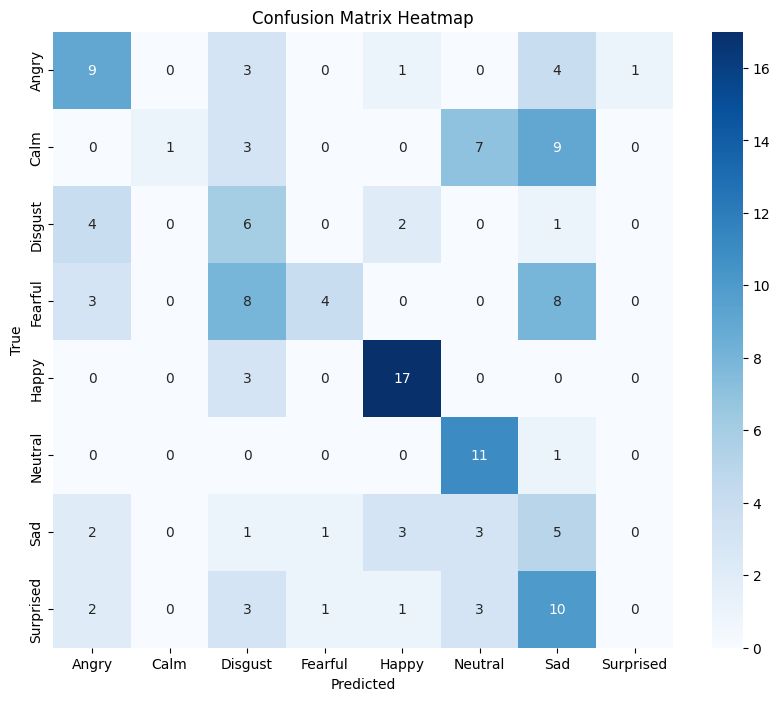

Heatmap saved as 'facs_confusion_heatmap.png'

Top Misclassifications (True → Predicted):
  Surprised    → Sad         : 10 times
  Calm         → Sad         : 9 times
  Fearful      → Sad         : 8 times
  Fearful      → Disgust     : 8 times
  Calm         → Neutral     : 7 times


In [38]:
# --- Evaluation (with Per-Class Recall) ---
model.load_state_dict(torch.load('facs_au_model.pth'))
model.to(device)
model.eval()
with torch.no_grad():
    test_outputs = []
    test_true = []
    for X_batch, y_batch, len_batch in test_loader:
        X_batch = X_batch.to(device)
        output = model(X_batch, len_batch)
        test_outputs.append(output.argmax(dim=1).cpu())
        test_true.append(y_batch.cpu())
    test_pred = torch.cat(test_outputs).numpy()
    test_true = torch.cat(test_true).numpy()

acc = accuracy_score(test_true, test_pred)
print(f"Final Test Accuracy: {acc * 100:.2f}%")

print("\nClassification Report:")
print(classification_report(test_true, test_pred, target_names=labels))

cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.savefig('facs_confusion_heatmap.png')
plt.show()
print("Heatmap saved as 'facs_confusion_heatmap.png'")

# NEW: Misclassification Analysis
print("\nTop Misclassifications (True → Predicted):")
misclassifications = []
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and cm[i, j] > 0:
            misclassifications.append((cm[i, j], labels[i], labels[j]))

misclassifications.sort(reverse=True)
for count, true_label, pred_label in misclassifications[:5]:
    print(f"  {true_label:12s} → {pred_label:12s}: {count} times")

In [1]:
# --- Test on a New Video (with Ensemble for Better Prediction) ---
test_video_path = os.path.join('testing', 'Happy', '01-01-03-02-01-02-23.mp4')  # Your path

features_list = extract_features_from_video(test_video_path)

if features_list:
    seq = [f for f in features_list if f is not None]  # Already flattened np.arrays
    if seq:
        # Apply same normalization + PCA as training
        seq_array = np.array(seq)
        norm_seq = scaler.transform(seq_array)  # Use training scaler
        reduced_seq = pca.transform(norm_seq)
        
        padded_seq = np.zeros((1, max_len, feature_dim_reduced), dtype=np.float32)
        actual_length = min(len(reduced_seq), max_len)
        padded_seq[0, :actual_length, :] = reduced_seq[:actual_length]

        padded_tensor = torch.tensor(padded_seq, dtype=torch.float32).to(device)
        test_length = torch.tensor([actual_length], dtype=torch.long)

        # Ensemble: Average 3 runs with different seeds (or load pre-trained ensembles if available)
        preds = []
        for seed in [42, 43, 44]:
            torch.manual_seed(seed)
            model.load_state_dict(torch.load('facs_au_model.pth'))
            model.to(device)
            model.eval()
            with torch.no_grad():
                output = model(padded_tensor, test_length)
                preds.append(torch.softmax(output, dim=1).cpu())
        
        avg_pred = torch.mean(torch.stack(preds), dim=0)
        pred_idx = avg_pred.argmax(dim=1).item()
        predicted_expression = labels[pred_idx]

        print(f"PREDICTED EXPRESSION FOR TEST VIDEO: {predicted_expression.upper()}")

NameError: name 'os' is not defined


TRAINING HISTORY VISUALIZATION


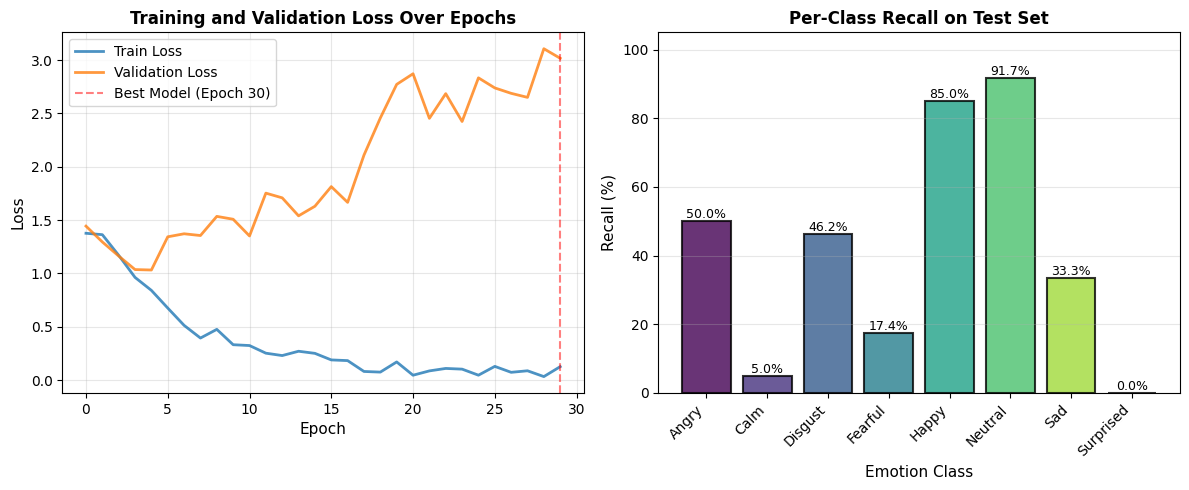

[OK] Training metrics saved as 'training_metrics_enhanced.png'


In [40]:
# --- Training Loss Visualization ---
print("\n" + "=" * 70)
print("TRAINING HISTORY VISUALIZATION")
print("=" * 70)

plt.figure(figsize=(12, 5))

# Plot 1: Loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2, alpha=0.8)
plt.plot(val_losses, label='Validation Loss', linewidth=2, alpha=0.8)
plt.axvline(x=best_epoch-1, color='red', linestyle='--', alpha=0.5, label=f'Best Model (Epoch {best_epoch})')
plt.xlabel('Epoch', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.title('Training and Validation Loss Over Epochs', fontsize=12, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Plot 2: Per-class accuracy improvement
plt.subplot(1, 2, 2)
from sklearn.metrics import recall_score
per_class_recall = recall_score(test_true, test_pred, average=None, zero_division=0)
colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))
bars = plt.bar(labels, per_class_recall * 100, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
plt.xlabel('Emotion Class', fontsize=11)
plt.ylabel('Recall (%)', fontsize=11)
plt.title('Per-Class Recall on Test Set', fontsize=12, fontweight='bold')
plt.ylim([0, 105])
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('training_metrics_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()
print("[OK] Training metrics saved as 'training_metrics_enhanced.png'")